<h1>Object detection with pytorch</h1>

This notebook demonstrates how to use transfer learning to train a Faster RCNN network for object detection. It uses a fairly simple dataset with images of 3 types of fruit (Apple, Banana, Orange) found at [fruit images for object detection](https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection). The images that contain merely one fruit are used for training purposes and the mixed ones for testing. Of course you can replace the provided data set with your own data set and this notebook should continue to work as intended.

Bas Michielsen MSc 2024

In [4]:
import datetime, glob, os, matplotlib, PIL, re, seaborn, torch, wget

from pvoc import load_pvoc_annotations

import torch
print("Torch version:", torch.__version__)

import torchvision
print("Torchvision version:", torchvision.__version__)

print("Is CUDA available?", torch.cuda.is_available())

Torch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
Is CUDA available? True


# Setup and download the reference scripts if needed
Define a number of paths. Also, Torchvision offers reference scripts that can be used to get started quickly. This notebook uses those scripts and downloads them if they are not present yet.

In [5]:
input_path = "input"
output_path = "output"

if not os.path.exists(output_path):
    os.mkdir(output_path)

files = ["coco_eval.py", "coco_utils.py", "engine.py", "transforms.py", "utils.py"]
for f in files:
    if not os.path.exists(f):
        wget.download("https://raw.githubusercontent.com/pytorch/vision/main/references/detection/" + f, f)
from engine import train_one_epoch

# Assert that the data files are present

In [6]:
train_data_path = "data/train"
test_data_path = "data/test"

for path in [train_data_path, test_data_path]:
    image_files = [x for x in os.listdir(path) if re.search(r'\.jpg$', x, re.IGNORECASE)]
    annotation_files = glob.glob(os.path.join(path, "*.xml"))
    if len(image_files) != len(annotation_files):
        raise Exception("WARNING: The number of jpeg images does not match the number of pvoc annotations in path:", path)
    else:
        print("Found", len(image_files), "jpeg images and pvoc annotations in path:", path)


Found 275 jpeg images and pvoc annotations in path: data/train
Found 25 jpeg images and pvoc annotations in path: data/test


# Create the datasets

In [7]:
from torchvision.datasets import VisionDataset
import torchvision.transforms.functional as transforms

class Dataset(VisionDataset):
    def __init__(self, root, data, classes, transforms=None, transform=None, target_transform=None):
        super().__init__(root, transforms, transform, target_transform)
        self.classes = classes
        self.images = glob.glob(os.path.join(self.root, "*.jpg"))
        self.data = data
        images = []
        for obj in data:
            filename = obj["filename"]
            if not filename in images:
                images.append(filename)
        self.images = images

    def __getitem__(self, i):
        image_path = os.path.join(self.root, self.images[i])
        image = PIL.Image.open(image_path).convert("RGB")
        objects, labels = [], []
        records = [x for x in self.data if x["filename"] == self.images[i]]
        for record in records:
            objects.append([int(record["xmin"]), int(record["ymin"]), int(record["xmax"]), int(record["ymax"])])
            labels.append(self.classes.index(record["name"]))
        boxes = torch.as_tensor(objects, dtype=torch.float32)
        target = {}
        target["boxes"] = boxes
        target["labels"] = torch.as_tensor(labels)
        target["image_id"] = torch.tensor([i])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0]) if len(boxes) > 0 else torch.zeros(1)
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        tensor = transforms.to_tensor(image)
        return tensor, target
    
    def __len__(self):
        return len(self.images)

train_data = load_pvoc_annotations(train_data_path)
test_data = load_pvoc_annotations(test_data_path)

classes = ["__background__"] + list(set(x["name"] for x in train_data))
print("The following classes were found:", classes)
train_dataset = Dataset(train_data_path, train_data, classes)
print("Train dataset size:", len(train_dataset))
test_dataset = Dataset(test_data_path, test_data, classes)
print("Test dataset size:", len(test_dataset))

The following classes were found: ['__background__', 'banana', 'apple', 'orange']
Train dataset size: 275
Test dataset size: 25


# Create a data loaders
If a lot of GPU memory is available the batch_size can be increased to speed up the training process.

In [8]:
batch_size = 24

def collate(batch):
    return tuple(zip(*batch))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate)

# Prepare the pretrained model
Prepare the pretrained model and replace the box predictor with a new one. For brevity here the mobileNet is chosen, however in reality the ResNet50_FPN_v2 is probably better (and slower).

In [9]:
import torchvision.models.detection as models
model = models.fasterrcnn_mobilenet_v3_large_320_fpn(weights="DEFAULT")
model.roi_heads.box_predictor = models.faster_rcnn.FastRCNNPredictor(model.roi_heads.box_predictor.cls_score.in_features, len(classes))

# Define a learning rate scheduler
By using a SGD optimizer.

In [10]:
from torch.optim import SGD, lr_scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Run the training
Run the training for a number of epochs

In [11]:
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("The selected device is:", device)

for epoch in range(epochs):
    train_result = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    train_metrics = train_result.__str__()
    scheduler.step()

The selected device is: cuda


d:\data\Documents\Projecten\fruit\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/12]  eta: 0:00:09  lr: 0.000459  loss: 2.6637 (2.6637)  loss_classifier: 1.3437 (1.3437)  loss_box_reg: 1.2965 (1.2965)  loss_objectness: 0.0164 (0.0164)  loss_rpn_box_reg: 0.0070 (0.0070)  time: 0.7766  data: 0.1215  max mem: 1929
Epoch: [0]  [10/12]  eta: 0:00:00  lr: 0.005000  loss: 2.1777 (2.0326)  loss_classifier: 1.0000 (1.0119)  loss_box_reg: 0.9674 (0.9916)  loss_objectness: 0.0222 (0.0221)  loss_rpn_box_reg: 0.0070 (0.0069)  time: 0.4846  data: 0.1971  max mem: 3235
Epoch: [0]  [11/12]  eta: 0:00:00  lr: 0.005000  loss: 2.0162 (1.9997)  loss_classifier: 0.9172 (0.9796)  loss_box_reg: 0.9674 (0.9925)  loss_objectness: 0.0196 (0.0210)  loss_rpn_box_reg: 0.0062 (0.0066)  time: 0.4628  data: 0.1841  max mem: 3235
Epoch: [0] Total time: 0:00:05 (0.4631 s / it)
Epoch: [1]  [ 0/12]  eta: 0:00:04  lr: 0.005000  loss: 1.3992 (1.3992)  loss_classifier: 0.5438 (0.5438)  loss_box_reg: 0.8178 (0.8178)  loss_objectness: 0.0288 (0.0288)  loss_rpn_box_reg: 0.0088 (0.0088)  tim

# Save the model and data to output path

In [12]:
model_output_path = os.path.join(output_path, datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
os.makedirs(model_output_path)
torch.save(model.state_dict(), os.path.join(model_output_path, "model"))

# Running against the test data

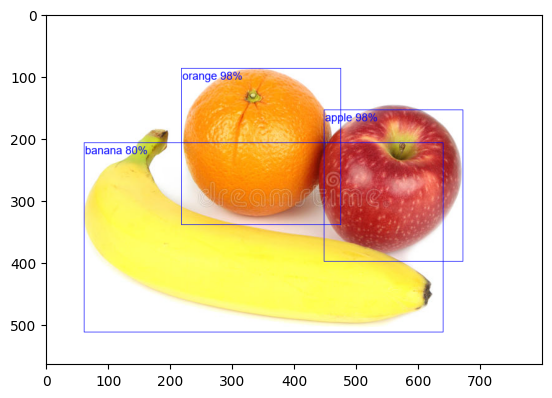

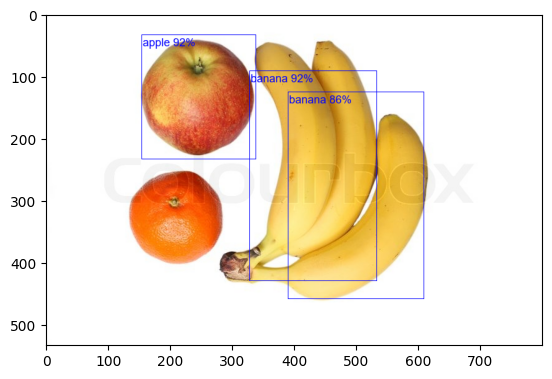

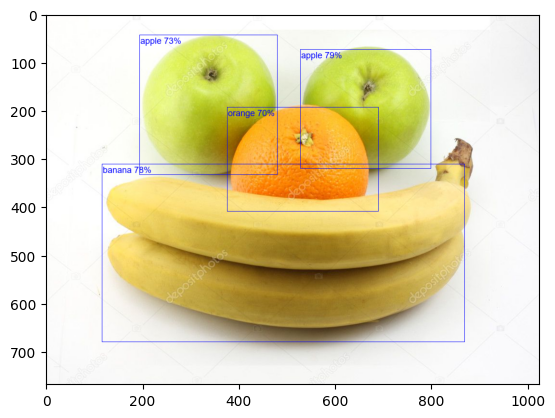

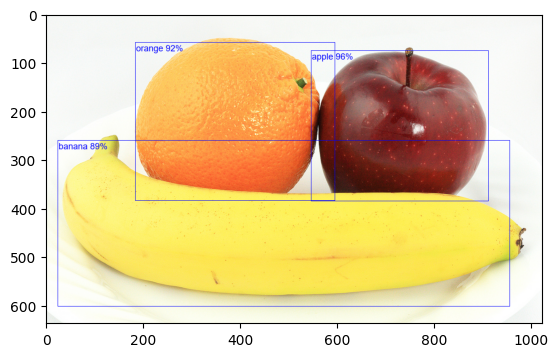

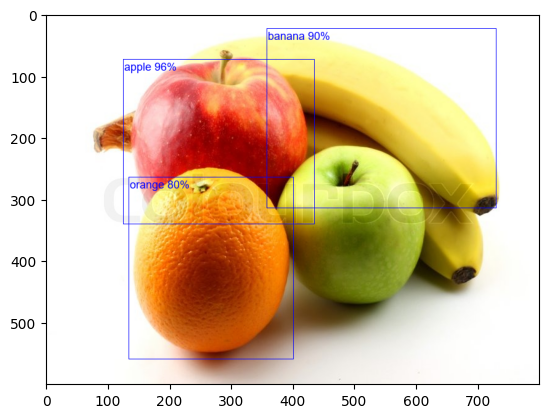

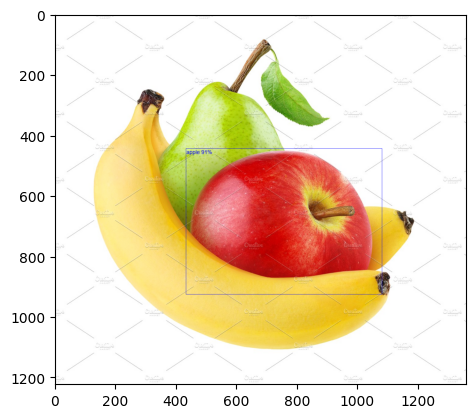

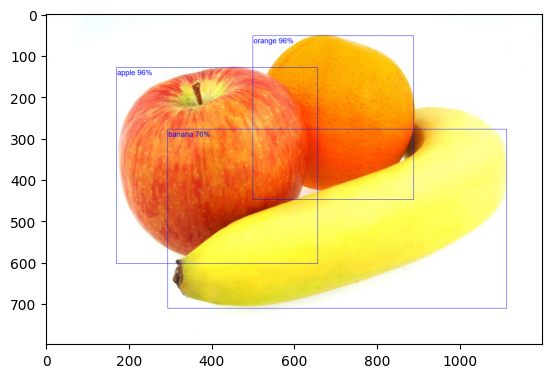

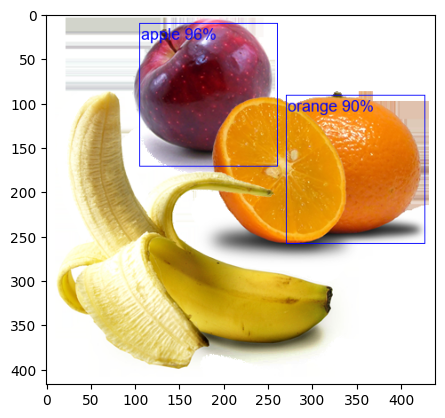

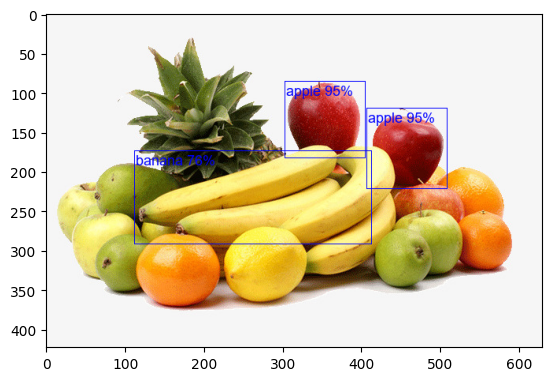

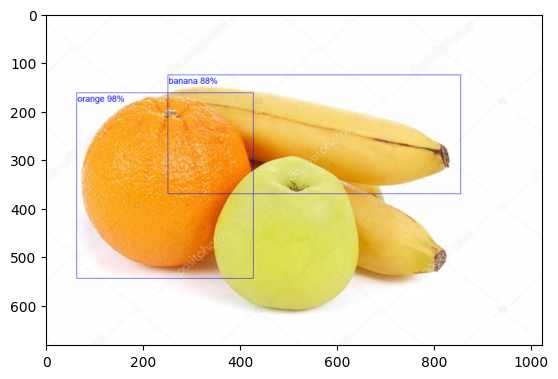

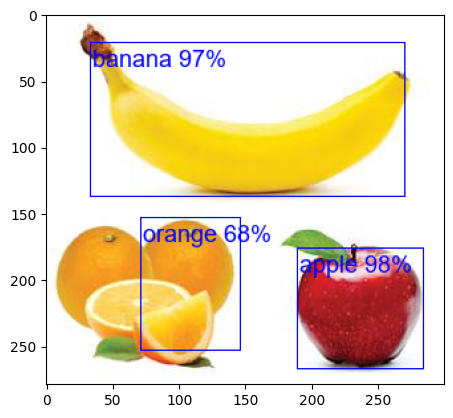

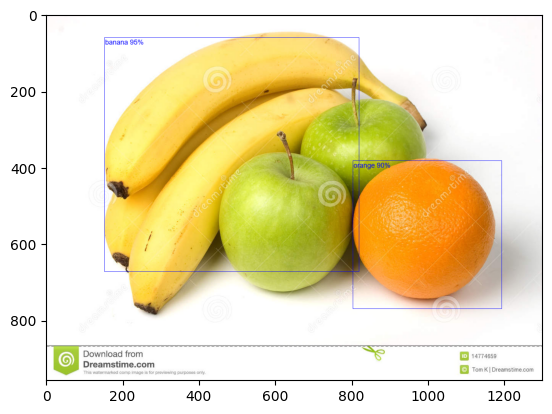

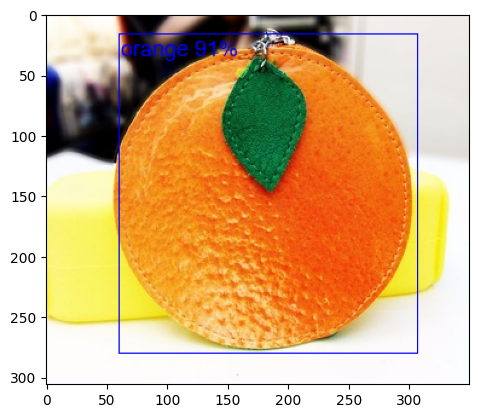

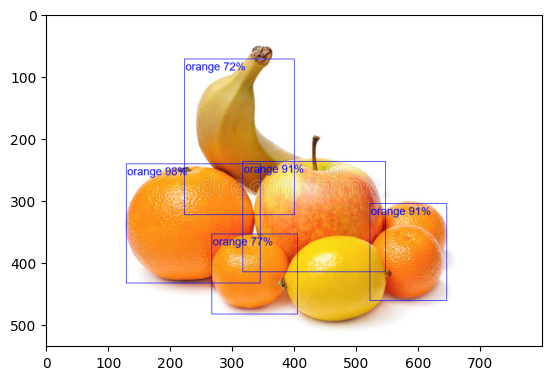

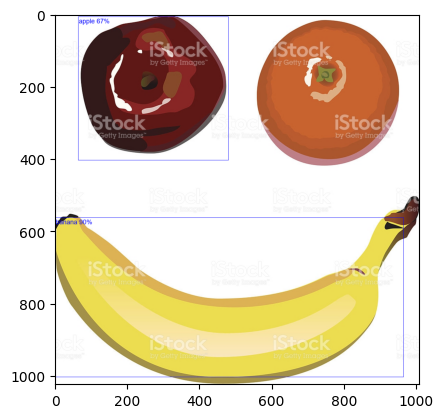

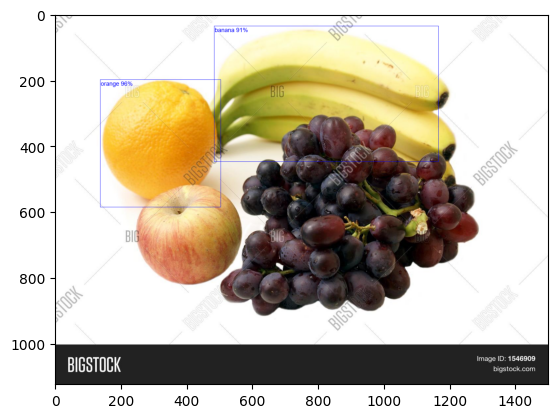

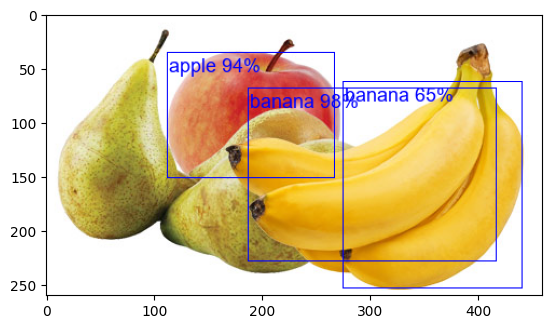

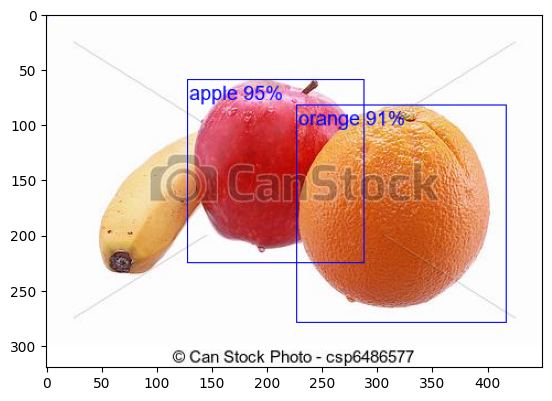

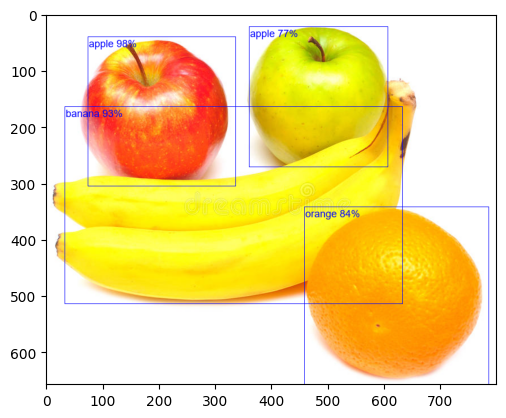

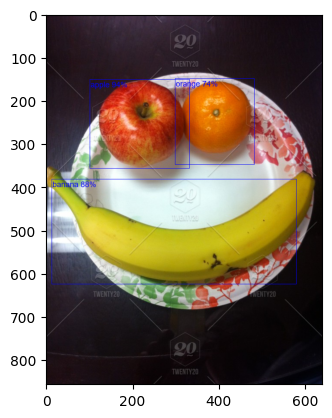

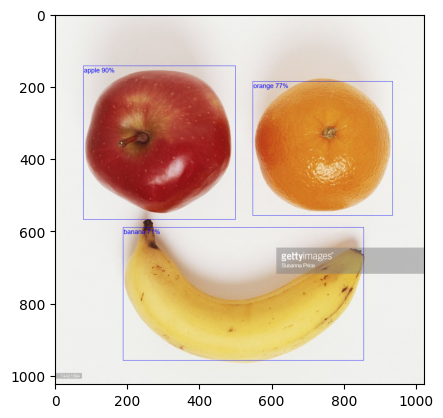

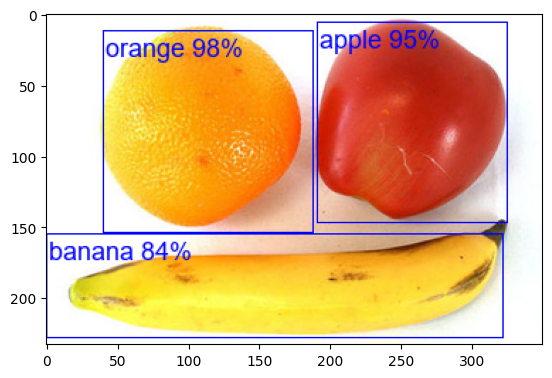

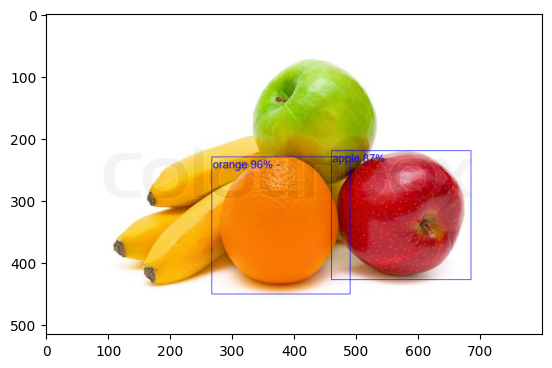

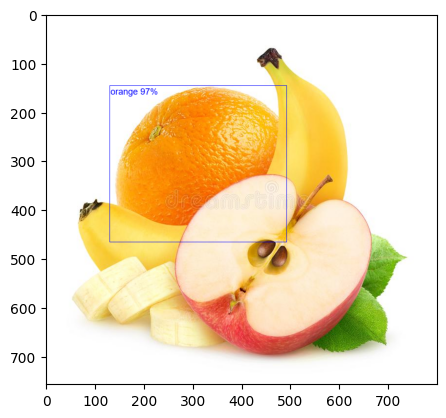

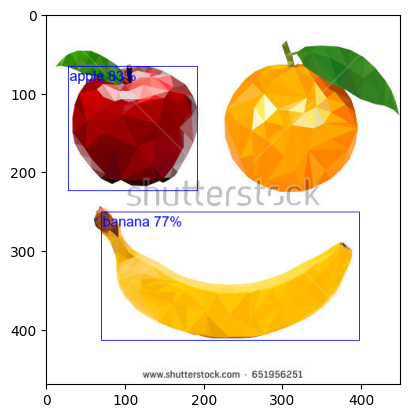

In [14]:
model_path = os.path.join(model_output_path, "model")

threshold = .6

from torchvision.utils import draw_bounding_boxes

def add_bounding_boxes(image, classes, predictions):
    if len(predictions[0]["boxes"]) == 0:
        return image
    annotations = [{'name': classes[p]} for p in predictions[0]["labels"].detach().numpy()]
    labels = ["{} {}%".format(label["name"], int(prob *100)) for label, prob in zip(annotations, predictions[0]["scores"].detach().numpy())]
    output = draw_bounding_boxes(image=image[0], boxes=predictions[0]["boxes"], labels=labels, colors="blue", width=1, font="arial.ttf", font_size=18)
    return transforms.to_pil_image(output) 

model = models.fasterrcnn_mobilenet_v3_large_320_fpn(weights="DEFAULT")
model.roi_heads.box_predictor = models.faster_rcnn.FastRCNNPredictor(model.roi_heads.box_predictor.cls_score.in_features, len(classes))
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

for image, _ in test_loader:
    predictions = model(image)
    predictions[0]["boxes"] = predictions[0]["boxes"][predictions[0]["scores"] > threshold]
    predictions[0]["labels"] = predictions[0]["labels"][predictions[0]["scores"] > threshold]
    predictions[0]["scores"] = predictions[0]["scores"][predictions[0]["scores"] > threshold]
    result = add_bounding_boxes(image, classes, predictions)
    matplotlib.pyplot.imshow(result)
    matplotlib.pyplot.show()
